In [ ]:
# -----------------------
# Loading the relevant libraries
# -----------------------
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# -----------------------
# CONFIG
# -----------------------
data_dir = "/content/drive/MyDrive/Deep Learning/Facial emotions datasets and models/test4_emotion_images - Copy"
img_size = (224, 224)
batch_size = 32
seed = 123

In [ ]:
# -----------------------
# STEP 1: Collect file paths and labels
# -----------------------
class_names = sorted(os.listdir(data_dir))
file_paths = []
labels = []

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_paths.append(os.path.join(class_dir, fname))
                labels.append(idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

In [ ]:
# -----------------------
# STEP 2: Stratified train/val split
# -----------------------
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=seed
)

In [ ]:
# -----------------------
# STEP 3: Data Augmentation
# -----------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [ ]:
# -----------------------
# STEP 4: Dataset builder
# -----------------------
def make_dataset(paths, labels, is_training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def process_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = img / 255.0  # normalize
        return img, label

    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(buffer_size=len(paths), seed=seed)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_paths, train_labels, is_training=True)
val_ds = make_dataset(val_paths, val_labels, is_training=False)

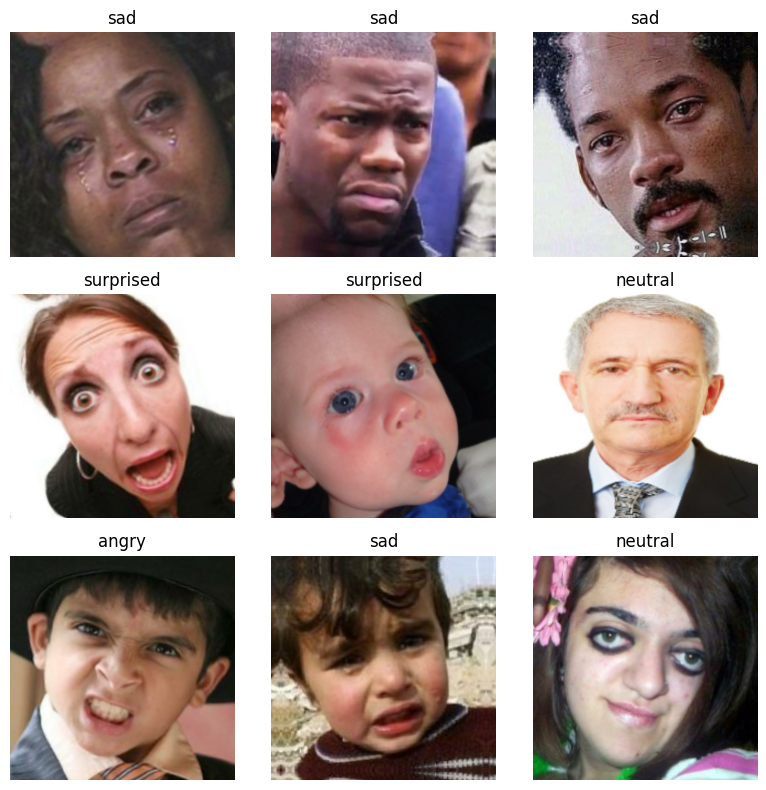

In [ ]:
# -----------------------
# Plot a few sample images
# -----------------------
def plot_sample_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show some training images
plot_sample_images(train_ds, class_names)


In [ ]:
# -----------------------
# STEP 5: Build Model (Transfer Learning with MobileNetV2)
# -----------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=img_size + (3,), include_top=False, weights="imagenet"
)
base_model.trainable = True
for layer in base_model.layers[:-40]:  # freeze earlier layers
    layer.trainable = False

inputs = keras.Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)  # regularization
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(inputs, outputs)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# -----------------------
# STEP 6: Compile
# -----------------------
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# -----------------------
# STEP 7: Callbacks
# -----------------------
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    )
]

In [ ]:
# -----------------------
# STEP 8: Train
# -----------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3422 - loss: 1.5987

132/132 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.3428 - loss: 1.5974 - val_accuracy: 0.3048 - val_loss: 2.3714
Epoch 2/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6001 - loss: 1.0356

132/132 ━━━━━━━━━━━━━━━━━━━━ 75s 87ms/step - accuracy: 0.6001 - loss: 1.0355 - val_accuracy: 0.3838 - val_loss: 1.8272
Epoch 3/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6728 - loss: 0.8735

132/132 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.6728 - loss: 0.8735 - val_accuracy: 0.5476 - val_loss: 1.2058
Epoch 4/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7093 - loss: 0.7757

132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.7093 - loss: 0.7757 - val_accuracy: 0.5800 - val_loss: 1.1919
Epoch 5/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 71s 119ms/step - accuracy: 0.7422 - loss: 0.6874 - val_accuracy: 0.5657 - val_loss: 1.2805
Epoch 6/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 76s 81ms/step - accuracy: 0.7850 - loss: 0.5709 - val_accuracy: 0.5648 - val_loss: 1.2435
Epoch 7/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 87s 121ms/step - accuracy: 0.8123 - loss: 0.5377 - val_accuracy: 0.5562 - val_loss: 1.3548
Epoch 8/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 80ms/step - accuracy: 0.8323 - loss: 0.4517 - val_accuracy: 0.5857 - val_loss: 1.2794
Epoch 9/30
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8499 - loss: 0.4162

132/132 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.8498 - loss: 0.4164 - val_accuracy: 0.5943 - val_loss: 1.1831
Epoch 10/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - accuracy: 0.8584 - loss: 0.3862 - val_accuracy: 0.5714 - val_loss: 1.3768
Epoch 11/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 67s 81ms/step - accuracy: 0.8810 - loss: 0.3229 - val_accuracy: 0.5438 - val_loss: 1.4563
Epoch 12/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 70s 119ms/step - accuracy: 0.8990 - loss: 0.2719 - val_accuracy: 0.5562 - val_loss: 1.6315
Epoch 13/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 82ms/step - accuracy: 0.9082 - loss: 0.2576 - val_accuracy: 0.5676 - val_loss: 1.4233
Epoch 14/30
132/132 ━━━━━━━━━━━━━━━━━━━━ 69s 121ms/step - accuracy: 0.9300 - loss: 0.2173 - val_accuracy: 0.5771 - val_loss: 1.5695


In [ ]:
# -----------------------
# STEP 9: Fine-tuning (optional, after initial training)
# -----------------------
# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-40]:  # freeze most, train last ~40
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8662 - loss: 0.3557

132/132 ━━━━━━━━━━━━━━━━━━━━ 100s 191ms/step - accuracy: 0.8662 - loss: 0.3556 - val_accuracy: 0.6181 - val_loss: 1.1501
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8917 - loss: 0.3072

132/132 ━━━━━━━━━━━━━━━━━━━━ 120s 90ms/step - accuracy: 0.8917 - loss: 0.3072 - val_accuracy: 0.6200 - val_loss: 1.1228
Epoch 3/10
131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8791 - loss: 0.3300

132/132 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.8791 - loss: 0.3297 - val_accuracy: 0.6324 - val_loss: 1.1160
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 63s 75ms/step - accuracy: 0.9033 - loss: 0.2960 - val_accuracy: 0.6314 - val_loss: 1.1169
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - accuracy: 0.9022 - loss: 0.2873 - val_accuracy: 0.6400 - val_loss: 1.1266
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8991 - loss: 0.2879

132/132 ━━━━━━━━━━━━━━━━━━━━ 66s 82ms/step - accuracy: 0.8992 - loss: 0.2878 - val_accuracy: 0.6448 - val_loss: 1.1150
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9092 - loss: 0.2636

132/132 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.9092 - loss: 0.2636 - val_accuracy: 0.6524 - val_loss: 1.1065
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 87s 124ms/step - accuracy: 0.9067 - loss: 0.2549 - val_accuracy: 0.6571 - val_loss: 1.1114
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 68s 83ms/step - accuracy: 0.9120 - loss: 0.2540 - val_accuracy: 0.6524 - val_loss: 1.1219
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - accuracy: 0.9141 - loss: 0.2516 - val_accuracy: 0.6524 - val_loss: 1.1210


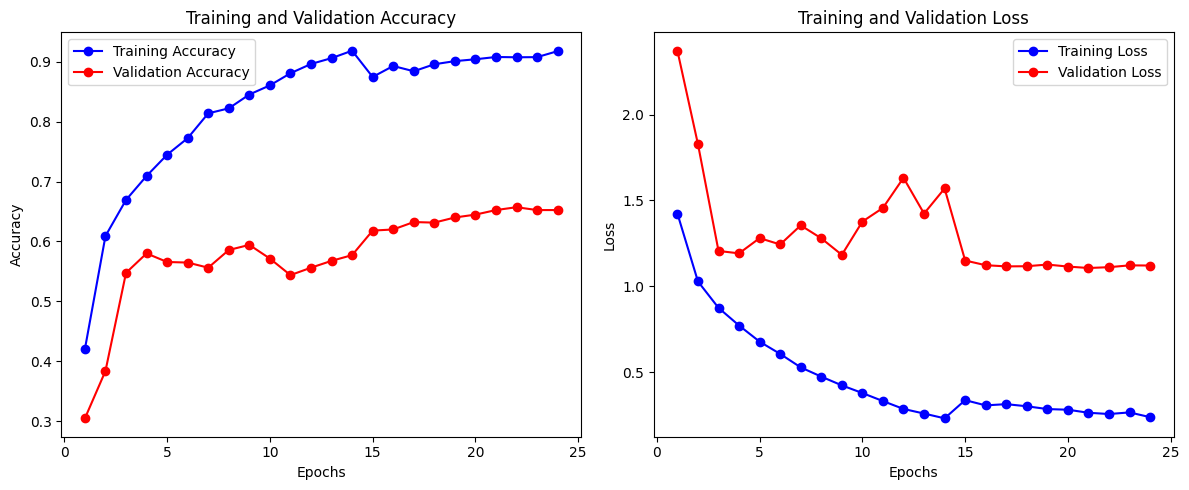

In [15]:
# -----------------------
# Plot Training History
# -----------------------
def plot_training_history(history, fine_tune_history=None):
    # Merge histories if fine-tuning is provided
    if fine_tune_history is not None:
        acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
        val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
        loss = history.history['loss'] + fine_tune_history.history['loss']
        val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_training_history(history, fine_tune_history)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# Evaluate Model on Validation Set
# -----------------------
def evaluate_model(model, val_ds, class_names):
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))


# Call the evaluation function
evaluate_model(model, val_ds, class_names)



Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.58      0.63       210
       happy       0.78      0.75      0.76       210
     neutral       0.52      0.60      0.56       210
         sad       0.62      0.62      0.62       210
   surprised       0.68      0.72      0.70       210

    accuracy                           0.65      1050
   macro avg       0.66      0.65      0.65      1050
weighted avg       0.66      0.65      0.65      1050

